# Feature Engineering

### Inititalizations

In [1]:
import ast
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from skmultilearn.model_selection import IterativeStratification
from sklearn.preprocessing import StandardScaler

from eval.metrics import Metrics

sns.set_style('whitegrid')

SEED = 42

In [2]:
# Data import
load_dotenv()

DATA_PATH = Path(os.getenv('PROJECT_ROOT'), '.') / 'data'
TRACKS_FILE = DATA_PATH / 'spotify_track_genres_preprocessed.csv'

tracks = pd.read_csv(TRACKS_FILE)
tracks['artist_genres'] = tracks['artist_genres'].apply(ast.literal_eval)

In [3]:
# Check data
tracks.info()
tracks.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10416 entries, 0 to 10415
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          10416 non-null  object 
 1   duration_ms       10416 non-null  int64  
 2   track_name        10416 non-null  object 
 3   track_popularity  10416 non-null  int64  
 4   acousticness      10416 non-null  float64
 5   danceability      10416 non-null  float64
 6   energy            10416 non-null  float64
 7   instrumentalness  10416 non-null  float64
 8   key               10416 non-null  int64  
 9   liveness          10416 non-null  float64
 10  loudness          10416 non-null  float64
 11  mode              10416 non-null  int64  
 12  speechiness       10416 non-null  float64
 13  tempo             10416 non-null  float64
 14  time_signature    10416 non-null  int64  
 15  valence           10416 non-null  float64
 16  artist_ids        10416 non-null  object

,duration_ms,track_popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,n_artists,n_genres
count,1.041600e+04,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000,10416.000000
mean,2.286264e+05,52.253744,0.360780,0.577236,0.564434,0.205984,5.245776,0.174369,-9.679182,0.612903,0.086908,117.952822,3.886425,0.473638,1.384121,4.404570
std,1.056449e+05,24.445176,0.353521,0.194247,0.275336,0.349380,3.554538,0.139941,6.641682,0.487109,0.088110,30.271137,0.439159,0.264467,0.787452,3.528924
min,2.560000e+04,0.000000,0.000002,0.000000,0.001100,0.000000,0.000000,0.015700,-47.903000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.736338e+05,40.000000,0.036650,0.452000,0.364000,0.000000,2.000000,0.093100,-11.953000,0.000000,0.036800,94.195500,4.000000,0.249000,1.000000,2.000000
50%,2.135395e+05,56.000000,0.216000,0.596000,0.603000,0.000190,5.000000,0.119000,-7.617500,1.000000,0.049000,118.005000,4.000000,0.472000,1.000000,4.000000
75%,2.584020e+05,71.000000,0.699000,0.726000,0.791000,0.266250,8.000000,0.206000,-5.264750,1.000000,0.091000,137.644500,4.000000,0.688000,2.000000,6.000000
max,2.668693e+06,100.000000,0.996000,0.979000,0.999000,0.994000,11.000000,1.000000,2.015000,1.000000,0.937000,217.969000,5.000000,0.988000,16.000000,91.000000


In [4]:
tracks.head()

,track_id,duration_ms,track_name,track_popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_ids,n_artists,artist_genres,n_genres
0,000u1dTg7y1XCDXi80hbBX,300600,I Don't Want A Lover,1,0.196000,0.756,0.470,0.000487,7,0.1260,-12.615,1,0.0394,120.484,4,0.4300,['5JsdVATHNPE0XdMFMRoSuf'],1,"[new wave pop, new romantic, scottish rock]",3
1,003FTlCpBTM4eSqYSWPv4H,233266,"Swing, Swing",70,0.000065,0.553,0.717,0.128000,7,0.0385,-5.857,1,0.0318,127.947,4,0.3180,['3vAaWhdBR38Q02ohXqaNHT'],1,"[modern rock, post-grunge, neon pop punk, pop ...",7
2,003vvx7Niy0yvhvHt4a68B,222973,Mr. Brightside,90,0.001210,0.352,0.911,0.000000,1,0.0995,-5.230,1,0.0747,148.033,4,0.2360,['0C0XlULifJtAgn6ZNCW2eu'],1,"[alternative rock, rock, permanent wave, moder...",5
3,008RKiNmjW5Lb6Ocumq6MA,298666,TWO OF US,46,0.927000,0.144,0.188,0.684000,4,0.1520,-13.680,0,0.0399,85.762,4,0.0743,['6mOCYCpXBAmulHN4kMfQaa'],1,[anime score],1
4,009ImBOrIUlWgla8U05RAC,228878,Unconditionally,82,0.002730,0.432,0.725,0.000000,7,0.2080,-4.862,1,0.0431,128.902,4,0.3530,['6jJ0s89eD6GaHleKKya26X'],1,[pop],1


#### Isolate relevant fields

In [5]:
RAW_TRAINING_FEATURES = [
    'duration_ms', 
    'acousticness', 
    'danceability', 
    'energy', 
    'instrumentalness', 
    'key', 
    'liveness', 
    'loudness', 
    'mode',
    'speechiness', 
    'tempo', 
    'time_signature', 
    'valence'
]

In [6]:
track_data = tracks[['track_id', 'artist_genres'] + RAW_TRAINING_FEATURES].copy()

### Label encoding

From the previously conducted EDA, it is apparent that the distribution of genres is highly skewed towards rare genres, reproduced below. This distribution gives rise to two problems:
- There is a possibility that a rare label can appear in the test set without appearing in the training set
- A rare label can appear in the training set without appearing in the test set, or it can appear too few times for sufficient training

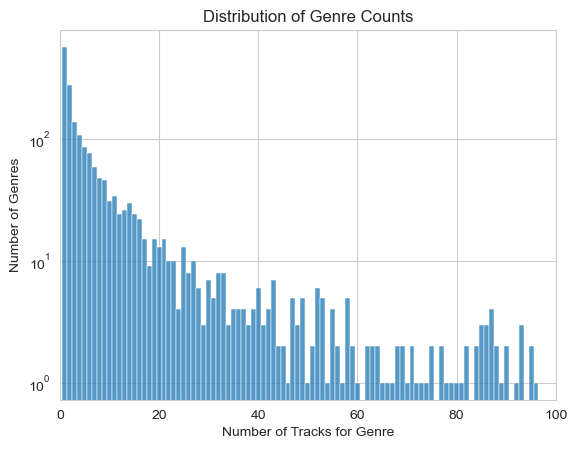

In [7]:
track_data_genre_exp = track_data[['artist_genres']].explode('artist_genres')
genre_counts = track_data_genre_exp['artist_genres'].value_counts()

plt.title('Distribution of Genre Counts')
plt.xlabel('Number of Tracks for Genre')
plt.ylabel('Number of Genres')
plt.yscale("log")
plt.xlim([0, 100])
sns.histplot(genre_counts, discrete=True)
plt.show()

For a train-test split of about 80-20, there should be at least five instances of any label such that one of them can appear in the training set. This is still most likely too low, since there can be rare combinations of genres as well. To increase the average number of training examples per label, the simplest method is to set a minimum number of instances for each label and discard the rarer ones. I will start by using 10 tracks per genre as a threshold.

In [8]:
GENRE_THRESHOLD = 100
total_genres = genre_counts.size
genre_subset = genre_counts[genre_counts >= GENRE_THRESHOLD].reset_index()['artist_genres']
print(f'Number of genres meeting or exceeding {GENRE_THRESHOLD} tracks: {genre_subset.size}')
print(f'{total_genres - genre_subset.size} of {total_genres} genres removed from dataset.')

Number of genres meeting or exceeding 100 tracks: 98
1889 of 1987 genres removed from dataset.


In [9]:
track_data_genre_exp = track_data_genre_exp[track_data_genre_exp['artist_genres'].isin(genre_subset)]
track_genre_pivot = pd.pivot_table(track_data_genre_exp, index=track_data_genre_exp.index, columns='artist_genres', aggfunc=lambda x: 1, fill_value=0)

In [10]:
track_data = track_data.merge(track_genre_pivot, left_index=True, right_index=True, how='inner').reset_index(drop=True)
track_data[genre_subset] = track_data[genre_subset].fillna(0)
track_data[genre_subset] = track_data[genre_subset].astype(int)
track_data.drop('artist_genres', axis=1, inplace=True)

In [11]:
print(f'After filtering, {100 * track_data.shape[0] / tracks.shape[0]:.1f}% of the dataset remains, {track_data.shape[0]} of {tracks.shape[0]} tracks.')

After filtering, 74.3% of the dataset remains, 7736 of 10416 tracks.


Despite the removal of over 70% of the labels, 94% of the data remains, because the genre frequency is distribution has a thick tail, i.e. the most common genres describing a large number of tracks.

This filtering serves as a useful tool for calibration and can be revisited to gauge model performance relative to different thresholds. For example, if the dataset is filtered to include genres with over 100 tracks, nearly 75% of the data remains, described by the top 98 genre labels, and this further reduction in label complexity may improve model performance.

### Feature transformations

In [12]:
# One-hot encode the categorical features
CATEGORICAL_FEATURES = [
    'key',
    'mode',
    'time_signature'
]
track_data = pd.get_dummies(track_data, columns=CATEGORICAL_FEATURES)

# Recreate list of feature names
non_categorical_features = [feature for feature in RAW_TRAINING_FEATURES if feature not in CATEGORICAL_FEATURES]
one_hot_features = [col for col in track_data.columns if any(col.startswith(f'{cat}_') for cat in CATEGORICAL_FEATURES)]
training_features = non_categorical_features + one_hot_features

# Convert booleans to integers
track_data[one_hot_features] = track_data[one_hot_features].astype(int)

Most of the numeric features are model outputs that are constrained in a range of 0-1 and can be left unchanged for baseline modeling. Several potential models would benefit from scaling the numerical features that extend past this range.

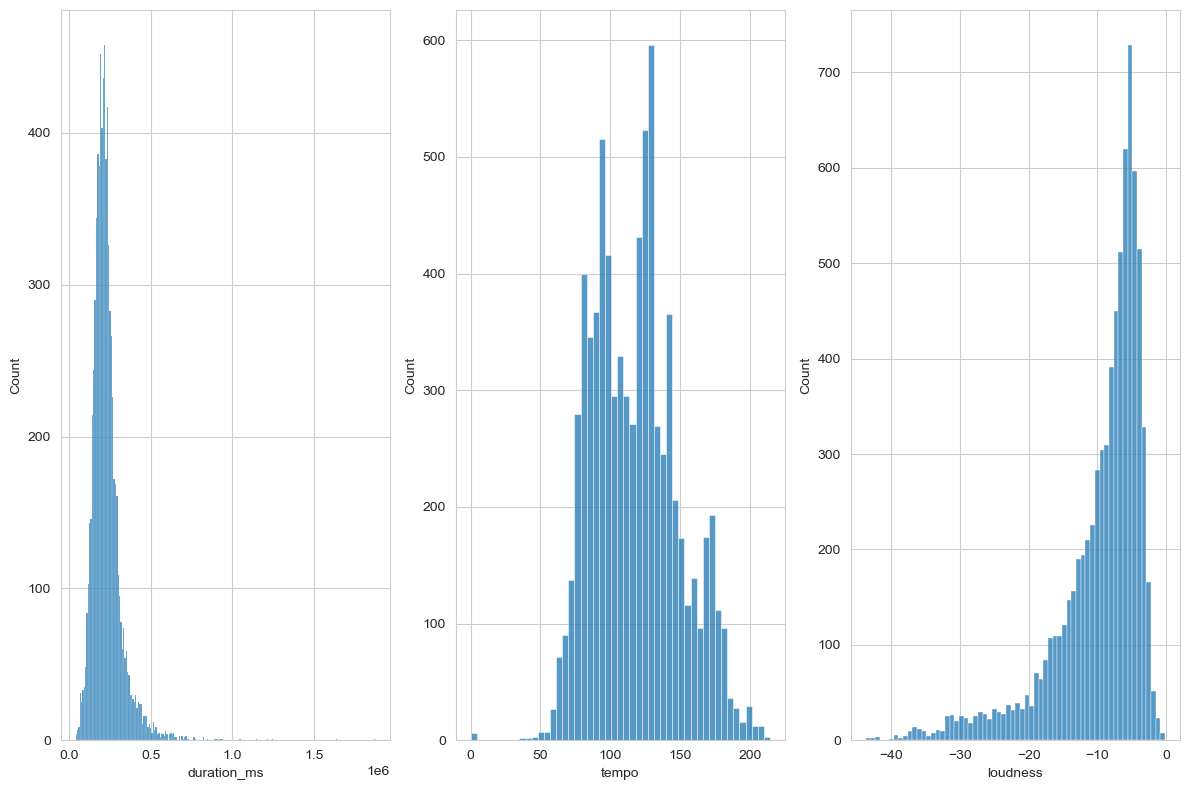

In [13]:
# Examine the distributions of unscaled continuous features
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
sns.histplot(track_data['duration_ms'])

plt.subplot(1, 3, 2)
sns.histplot(track_data['tempo'])

plt.subplot(1, 3, 3)
sns.histplot(track_data['loudness'])

plt.tight_layout()
plt.show()

Of these three, the distribution of tempo is probably the most straightforward, as it is centrally distributed within a relatively narrow range. Although the underlying data is most likely multi-modal, standard scaling is appropriate for a first pass.

Several attempts at transforming loudness were attempted (log-scaling, square-root scaling, Yeo-Johnson, omitted here for clarity), but did not reduce the skew. Because the distribution is also confined to a relatively narrow range, I will try standard-scaling here as well. Many of the model output features are also skewed within their 0-1 range, so these can all be revisited in later iterations, if necessary.

The duration distribution has a very long tail and is a good candidate for a log transformation.

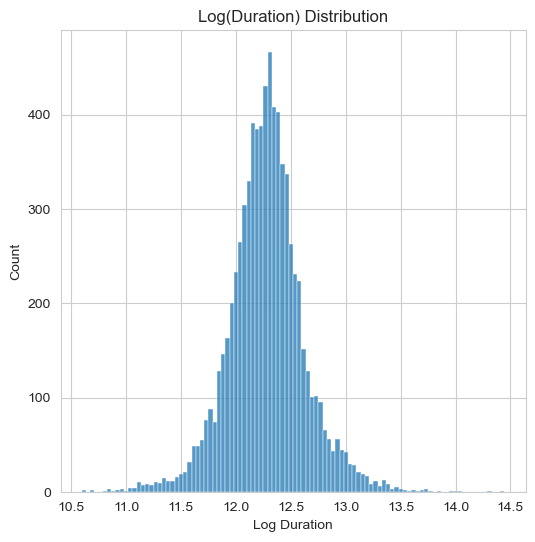

In [14]:
# Plot the log of duration
plt.figure(figsize=(6, 6))

plt.title('Log(Duration) Distribution')
plt.xlabel('Log Duration')
sns.histplot(np.log(track_data['duration_ms']))

plt.show()

The log of duration appears to be normally distributed, so standard scaling after this transformation is a good choice.

In [15]:
# Log transform the duration
track_data['duration_ms'] = np.log(track_data['duration_ms'])

#### Stratified Split of Data

To avoid data leakage, it is necessary to split the data prior to scaling the numeric features. In multi-label classification, this can be challenging due to the rarity of labels or label features. The filtering from earlier will help alleviate this issue, but it is also beneficial to stratify the labels across splits such that there is an appropriate distribution between the training and test datasets.

The scikit-multilearn library includes functionality to iteratively split datasets maintaining a label distribution. Below, I make a slight change to one of the built-in functions to allow for easily splitting the track_ids as well as the dataset.

In [16]:
def iterative_train_test_split(features, labels, identifiers, test_size):
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0 - test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    features_train, labels_train, identifiers_train= features[train_indexes, :], labels[train_indexes, :], identifiers[train_indexes]
    features_test, labels_test, identifiers_test = features[test_indexes, :], labels[test_indexes, :], identifiers[test_indexes]

    return features_train, labels_train, identifiers_train, features_test, labels_test, identifiers_test

In [17]:
# Separate features, labels, and ids, and perform stratified split
X = track_data[training_features]
y = track_data[genre_subset]
ids = track_data['track_id']

X_train, y_train, ids_train, X_test, y_test, ids_test = iterative_train_test_split(X.to_numpy(), y.to_numpy(), ids.to_numpy(), test_size=0.2)

In [18]:
# Convert data back into pandas structures for now to allow for easier manipulation
X_train = pd.DataFrame(X_train, columns=training_features)
X_test = pd.DataFrame(X_test, columns=training_features)

y_train = pd.DataFrame(y_train, columns=genre_subset)
y_test = pd.DataFrame(y_test, columns=genre_subset)

ids_train = pd.Series(ids_train, name='track_id')
ids_test = pd.Series(ids_test, name='track_id')

In [19]:
y_test.sum(axis=0)

artist_genres
rap                    219
pop                    170
hip hop                168
rock                   150
pop rap                122
                      ... 
british orchestra       24
k-pop girl group        21
world                   20
underground hip hop     20
soul blues              22
Length: 98, dtype: int64

In [20]:
# Inspect characteristics of split
## TODO

#### Numeric Scaling

The final transformation will be applying the numeric scaling to the features explored above. After this scaling, the data should be ready for baseline modeling.

In [21]:
scaler = StandardScaler()
X_train[['duration_ms', 'tempo', 'loudness']] = scaler.fit_transform(X_train[['duration_ms', 'tempo', 'loudness']])
X_test[['duration_ms', 'tempo', 'loudness']] = scaler.transform(X_test[['duration_ms', 'tempo', 'loudness']])

In [22]:
X_train.head()

,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.217697,0.000065,0.553,0.7170,0.128000,0.0385,0.562765,0.0318,0.335976,0.3180,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.089359,0.001210,0.352,0.9110,0.000000,0.0995,0.656263,0.0747,0.991409,0.2360,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.765438,0.995000,0.355,0.0164,0.926000,0.0986,-2.837455,0.0396,-1.621936,0.0922,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.091355,0.086800,0.675,0.9860,0.000005,0.1280,0.749313,0.0974,0.272573,0.5700,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.272950,0.019500,0.723,0.9400,0.000518,0.0933,1.155365,0.0728,-0.574797,0.4060,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [23]:
# Convert back to numpy arrays for modeling
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

### Baseline Modeling

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

In [34]:
br_classifier = BinaryRelevance(GaussianNB())
cc_classifier = ClassifierChain(LogisticRegression(max_iter=1000, random_state=SEED))
lp_classifier = LabelPowerset(LogisticRegression(max_iter=1000, random_state=SEED))

In [44]:
_ = br_classifier.fit(X_train, y_train)

In [45]:
_ = cc_classifier.fit(X_train, y_train)

In [46]:
_ = lp_classifier.fit(X_train, y_train)

In [47]:
br_predictions = br_classifier.predict(X_test)
cc_predictions = cc_classifier.predict(X_test)
lp_predictions = lp_classifier.predict(X_test)

In [48]:
br_output_metrics = Metrics(y_test, br_predictions, genre_subset)
cc_output_metrics = Metrics(y_test, cc_predictions, genre_subset)
lp_output_metrics = Metrics(y_test, lp_predictions, genre_subset)

In [49]:
br_output_metrics.print_metrics()

Hamming Loss: 0.4970
Jaccard Score (Weighted Avg): 0.0947
                        precision    recall  f1-score   support
             micro avg      0.055     0.940     0.104      4662
             macro avg      0.069     0.939     0.121      4662
          weighted avg      0.097     0.940     0.164      4662
           samples avg      0.065     0.930     0.116      4662


In [50]:
cc_output_metrics.print_metrics()

Hamming Loss: 0.0321
Jaccard Score (Weighted Avg): 0.1252
                        precision    recall  f1-score   support
             micro avg      0.438     0.167     0.242      4662
             macro avg      0.329     0.120     0.146      4662
          weighted avg      0.394     0.167     0.197      4662
           samples avg      0.182     0.188     0.175      4662


In [51]:
lp_output_metrics.print_metrics()

Hamming Loss: 0.0397
Jaccard Score (Weighted Avg): 0.1060
                        precision    recall  f1-score   support
             micro avg      0.282     0.190     0.227      4662
             macro avg      0.291     0.179     0.160      4662
          weighted avg      0.334     0.190     0.176      4662
           samples avg      0.294     0.273     0.269      4662
